In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
import numpy as np

In [18]:
print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

CUDA: False


device(type='cpu')

In [11]:
def angular_spectrum_propagation(U0, wvl, dx, z):
    """
    Propagates an optical field using the Bandlimited Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 4D torch tensor (batch, channel, x, y)
        wvl     : float (wavelength of light in meters)
        dx      : float (sampling interval in meters)
        z       : float (propagation distance in meters)

    Returns:
        U1  : the propagated field (same shape as U0)
    """
    batch, channel, original_height, original_width = U0.shape
    pad_height, pad_width = original_height // 2, original_width // 2

    z = torch.tensor([z], device=U0.device)
    # Pad input field
    U0_padded = torch.zeros((batch, channel, original_height + 2 * pad_height, original_width + 2 * pad_width), dtype=U0.dtype, device=U0.device)
    U0_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width] = U0

    ny, nx = U0_padded.shape[-2:]
    k = 2 * torch.pi / wvl

    # Create spatial frequency coordinates
    fx = torch.fft.fftfreq(nx, dx, device=U0.device)
    fy = torch.fft.fftfreq(ny, dx, device=U0.device)
    FX, FY = torch.meshgrid(fx, fy)  # Ensure FX and FY have last two dimensions
    FX = FX.reshape(1,1, FX.shape[0], FX.shape[1])
    FY = FY.reshape(1,1, FY.shape[0], FY.shape[1])

    Delta_uy = 1 / (ny * dx)
    Delta_ux = 1 / (nx * dx)
    u_limity = 1 / (torch.sqrt((2 * Delta_uy * z) ** 2 + 1) * wvl)
    u_limitx = 1 / (torch.sqrt((2 * Delta_ux * z) ** 2 + 1) * wvl)
    H_limit = ((FY ** 2 / u_limity ** 2 + FX ** 2 * wvl ** 2) < 1) * ((FX ** 2 / u_limitx ** 2 + FY ** 2 * wvl ** 2) < 1)

    # Kernel
    H = torch.exp(1j * k * z * torch.sqrt(1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    # Propagate
    U1_padded = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fft2(torch.fft.ifftshift(U0_padded, dim=(-2, -1))) * H * H_limit), dim=(-2, -1))

    # Extract to initial size
    U1 = U1_padded[:, :, pad_height:pad_height + original_height, pad_width:pad_width + original_width]

    return U1

# CW08 Part 2
You are given a complex field (`torch.tensor(np.load("field_propagated.npy")).to(device)`).

Apply phase conjugation and propagate the field back through the scattering layer (`torch.tensor(np.load("random_media.npy")).to(device)`).

The wavelength is `633nm` and `dx=1µm`. The propagation distance between the sample and the scattering layer is `1mm`. The distance between the scattering layer and the detector is also `1mm`.

In [24]:
S = torch.tensor(np.load("random_media.npy")).to(device)

In [25]:
Up = torch.tensor(np.load("field_propagated.npy")).to(device)

In [26]:
P = lambda x: angular_spectrum_propagation(x.reshape(1,1,x.shape[0],x.shape[1]), 633e-9,1e-6,1e-3).reshape(x.shape[0],x.shape[1])

In [39]:
U_recovered = P(S * P(Up.conj()))

In [40]:
# or you can also do this:
P_rev = lambda x: angular_spectrum_propagation(x.reshape(1,1,x.shape[0],x.shape[1]), 633e-9,1e-6,-1e-3).reshape(x.shape[0],x.shape[1])
U_recovered2 = P_rev(S.conj() * P_rev(Up))

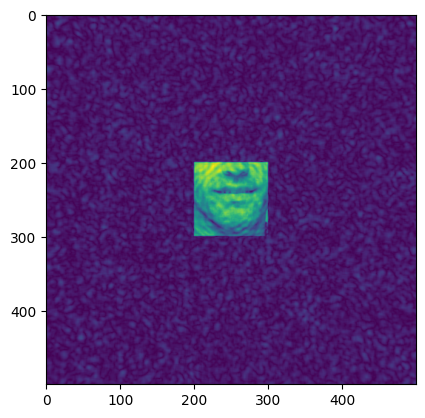

In [41]:
plt.imshow(torch.abs(U_recovered2))

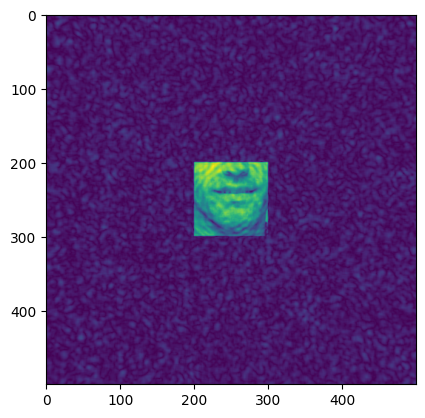

In [42]:
plt.imshow(torch.abs(U_recovered))